In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display
import numpy as np
import librosa
import tensorflow as tf
import glob

In [2]:
c_drone_path = '../../../1mtest/*.wav'
cm_drone_path = '../../../10mtest/*.wav'
m_drone_path = '../../../20mtest/*.wav'
f_drone_path = '../../../50mtest/*.wav'
background_path = '../../../backgroundtest/*.wav'
c_drone_files = glob.glob(c_drone_path)
cm_drone_files = glob.glob(cm_drone_path)
m_drone_files = glob.glob(m_drone_path)
f_drone_files = glob.glob(f_drone_path)
background_files = glob.glob(background_path)

In [3]:
CHUNK_SIZE = 8192
SR = 22050
N_MFCC = 16

In [4]:
def load(files, sr=22050):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
c_drone_raw = load(c_drone_files)
cm_drone_raw = load(cm_drone_files)
m_drone_raw = load(m_drone_files)
f_drone_raw = load(f_drone_files)
background_raw = load(background_files)

(143360,)
(143360,)
(143360,)
(143360,)
(91372,)


In [6]:
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=22050, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc, n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print(i,">small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0], mfcc_slice.shape[1]))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

In [7]:
c_mfcc_drone, c_y_drone = mfcc4(c_drone_raw, 4)
cm_mfcc_drone, cm_y_drone = mfcc4(cm_drone_raw, 3)
m_mfcc_drone, m_y_drone = mfcc4(m_drone_raw, 2)
f_mfcc_drone, f_y_drone = mfcc4(f_drone_raw, 1)
mfcc_background, y_background = mfcc4(background_raw, 0)

print(c_mfcc_drone.shape, c_y_drone.shape)
print(cm_mfcc_drone.shape, cm_y_drone.shape)
print(m_mfcc_drone.shape, m_y_drone.shape)
print(f_mfcc_drone.shape, f_y_drone.shape)

print(mfcc_background.shape, y_background.shape)

(143360,)
139264 >small end: (16, 9)
(143360,)
139264 >small end: (16, 9)
(143360,)
139264 >small end: (16, 9)
(143360,)
139264 >small end: (16, 9)
(91372,)
86016 >small end: (16, 11)
90112 >small end: (16, 3)
(34, 16, 16) (34,)
(34, 16, 16) (34,)
(34, 16, 16) (34,)
(34, 16, 16) (34,)
(21, 16, 16) (21,)


In [8]:
X = np.concatenate((c_mfcc_drone,cm_mfcc_drone,m_mfcc_drone,f_mfcc_drone, mfcc_background), axis=0)
y = np.hstack((c_y_drone, cm_y_drone,m_y_drone, f_y_drone, y_background))
print(X.shape, y.shape)

(157, 16, 16) (157,)


In [9]:
X_test = np.reshape(X,(X.shape[0],-1))
print(X_test.shape)
print(type(X_test))

(157, 256)
<class 'numpy.ndarray'>


In [10]:
#X_train2 = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) ############# 리셰입 해야 

In [11]:
n_labels = y.shape[0]
n_unique_labels = 5
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)

(157, 5)


# test init

In [12]:
tf.reset_default_graph()

In [13]:
n_mfcc = 16
n_frame = 16
n_classes = 5
n_channels = 1

kernel_size = 3
stride = 1
pad = "SAME"

learning_rate = 0.0002

In [14]:
X = tf.placeholder(tf.float32, shape=[None,n_mfcc*n_frame*n_channels])
#X = tf.reshape(X, [-1, n_mfcc, n_frame, n_channels]) #fully connected에는 리셰입 안해도 된다 
Y = tf.placeholder(tf.float32, shape=[None,n_classes])

keep_prob = tf.placeholder(tf.float32)

#dense2 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
#dropout2 = tf.layers.dropout(inputs=dense2, rate=0.5, training=True)
dense1 = tf.layers.dense(inputs=X, units=256, activation=tf.nn.relu)
dropout1 = tf.nn.dropout(dense1, keep_prob=keep_prob)
dense2 = tf.layers.dense(inputs=dropout1, units=256, activation=tf.nn.relu)
dropout2 = tf.nn.dropout(dense2, keep_prob=keep_prob)
dense3 = tf.layers.dense(inputs=dropout2, units=512, activation=tf.nn.relu)
dropout3 = tf.nn.dropout(dense3, keep_prob=keep_prob)
#이거 지워보고 돌려보고 
dense4 = tf.layers.dense(inputs=dropout3, units=512, activation=tf.nn.relu)
dropout4 = tf.nn.dropout(dense4, keep_prob=keep_prob)
dense5 = tf.layers.dense(inputs=dropout4, units=256, activation=tf.nn.relu)
dropout5 = tf.nn.dropout(dense5, keep_prob=keep_prob)

logits= tf.layers.dense(inputs=dropout5, units=5)

In [15]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [16]:
# Model Save
sess=tf.Session()
saver = tf.train.Saver()
saver.restore(sess, '../../model/Dense/4_dense_model')

INFO:tensorflow:Restoring parameters from ../../model/Dense/4_dense_model


In [17]:
# Prediction
y_test = sess.run(tf.nn.softmax(logits), feed_dict={X: X_test, keep_prob:1})
y_pred = sess.run(tf.argmax(logits,1),feed_dict={X: X_test , keep_prob:1}) 
y_true = sess.run(tf.argmax(y_encoded,1))
print(type(y_test))

<class 'numpy.ndarray'>


In [18]:
import pandas as pd
pd.options.display.max_rows = 4000
print(pd.DataFrame(y_test))
print(len(y_test))

            0             1             2             3             4
0    0.000000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
1    0.000000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
2    0.000000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
3    0.000000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
4    0.000000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
5    0.000000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
6    0.000000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
7    0.000000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
8    0.000000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
9    0.000000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
10   0.000000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
11   0.000000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
12   0.000000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
13   0.000000  0.000

In [19]:
dis = []
disX = []
mean = []
tmp = 0
meanX = [0,1,10,20,50]
meanY = []
# 0
for i in range(137,156):
    distance = y_test[i][0]*(-2) + y_test[i][1]*50 + y_test[i][2]*20 + y_test[i][3]*10 + y_test[i][4]
    tmp = tmp + distance
    dis.append(round(distance,4))
    disX.append(0)
meanY.append(tmp/20)
print(tmp/20)
tmp = 0
# 4
for i in range(0,19):
    distance = y_test[i][0]*(-2) + y_test[i][1]*50 + y_test[i][2]*20 + y_test[i][3]*10 + y_test[i][4]
    tmp = tmp + distance
    dis.append(round(distance,4))
    disX.append(1)
meanY.append(tmp/20)
print(tmp/20)
tmp = 0
# 3
for i in range(50,69):
    distance = y_test[i][0]*(-2) + y_test[i][1]*50 + y_test[i][2]*20 + y_test[i][3]*10 + y_test[i][4]
    tmp = tmp + distance
    dis.append(round(distance,4))
    disX.append(10)
meanY.append(tmp/20)
print(tmp/20)
tmp = 0
# 2
for i in range(72,91):
    distance = y_test[i][0]*(-2) + y_test[i][1]*50 + y_test[i][2]*20 + y_test[i][3]*10 + y_test[i][4]
    tmp = tmp + distance
    dis.append(round(distance,4))
    disX.append(20)
meanY.append(tmp/20)
print(tmp/20)
tmp = 0
# 1
for i in range(115,134):
    distance = y_test[i][0]*(-2) + y_test[i][1]*50 + y_test[i][2]*20 + y_test[i][3]*10 + y_test[i][4]
    tmp = tmp + distance
    dis.append(round(distance,4))
    disX.append(50)
meanY.append(tmp/20)
print(tmp/20)



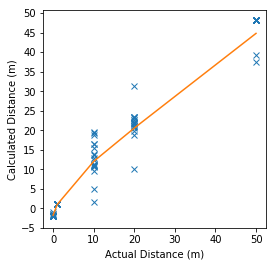

In [20]:

fig= plt.figure(figsize=(4,4))
axes= fig.add_subplot(111)

#axes.set_xticks([0,50, 20, 10, 1])


axes.plot(disX, dis,'x')
plt.xlabel('Actual Distance (m)')
plt.ylabel('Calculated Distance (m)')
axes.plot(meanX, meanY)
axes.set_yticks([0,5,10,15,20,25,30,35,40,45,50,-5])
#plt.show()

plt.savefig('graph.png',dpi=900)


F-Score: 0.87
Accuracy:  0.8662420382165605
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        21
           1       1.00      0.97      0.99        34
           2       0.70      0.76      0.73        34
           3       1.00      0.65      0.79        34
           4       0.94      1.00      0.97        34

   micro avg       0.87      0.87      0.87       157
   macro avg       0.87      0.88      0.86       157
weighted avg       0.89      0.87      0.86       157

[[21  0  0  0  0]
 [ 0 33  1  0  0]
 [ 8  0 26  0  0]
 [ 0  0 10 22  2]
 [ 0  0  0  0 34]]


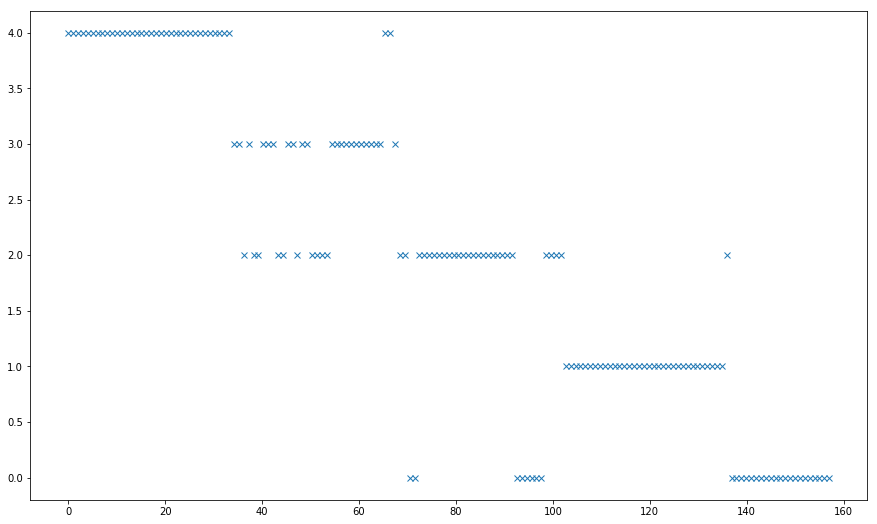

In [21]:
# Print Result

from sklearn.metrics import precision_recall_fscore_support
y_true = y_true
y_pred = y_pred

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,2))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))


#fig = plt.figure(figsize=(15,9))
#ax = fig.add_subplot(1,1,1)
#ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_true, 'x')


fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_pred, 'x')

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

In [22]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_true, y_pred)

In [23]:
print(mat)

[[21  0  0  0  0]
 [ 0 33  1  0  0]
 [ 8  0 26  0  0]
 [ 0  0 10 22  2]
 [ 0  0  0  0 34]]


In [24]:
print(mat[0])

[21  0  0  0  0]
